# Dataset preparation

## Creating CSV file

In [ ]:
%pip install feedparser

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.1 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=4933596e787e9c4886b1cd06cee6411cc8e2bbc14564713f71e037d1f2475c3c
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [ ]:
%pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.2 MB/s eta 0:00:00


In [ ]:
import requests
import feedparser
import csv
import textstat
import time
from datetime import datetime
import pytz

In [ ]:
base_url = 'http://export.arxiv.org/api/query?'

In [ ]:
def fetch_arxiv_articles(search_query, max_results=1000, results_per_request=1000):
    articles = []
    for batch_number, start in enumerate(range(0, max_results, results_per_request), 1):
        query = f"search_query={search_query}&start={start}&max_results={results_per_request}"
        response = requests.get(base_url + query)
        print(f"Batch {batch_number}: Status Code {response.status_code}")  # Print batch number and status code

        # Parse the response using feedparser
        feed = feedparser.parse(response.text)
        articles.extend(feed.entries)

        # To avoid hitting the API limit, add a delay between requests
        time.sleep(3)

    return articles

In [ ]:
search_query = 'cat:cs.AI'  # Category: Computer Science > Artificial Intelligence

In [ ]:
articles = fetch_arxiv_articles(search_query, max_results=103671, results_per_request=1000)

Batch 1: Status Code 200
Batch 2: Status Code 200
Batch 3: Status Code 200
Batch 4: Status Code 200
Batch 5: Status Code 200
Batch 6: Status Code 200
Batch 7: Status Code 200
Batch 8: Status Code 200
Batch 9: Status Code 200
Batch 10: Status Code 200
Batch 11: Status Code 200
Batch 12: Status Code 200
Batch 13: Status Code 200
Batch 14: Status Code 200
Batch 15: Status Code 200
Batch 16: Status Code 200
Batch 17: Status Code 200
Batch 18: Status Code 200
Batch 19: Status Code 200
Batch 20: Status Code 200
Batch 21: Status Code 200
Batch 22: Status Code 200
Batch 23: Status Code 200
Batch 24: Status Code 200
Batch 25: Status Code 200
Batch 26: Status Code 200
Batch 27: Status Code 200
Batch 28: Status Code 200
Batch 29: Status Code 200
Batch 30: Status Code 200
Batch 31: Status Code 200
Batch 32: Status Code 200
Batch 33: Status Code 200
Batch 34: Status Code 200
Batch 35: Status Code 200
Batch 36: Status Code 200
Batch 37: Status Code 200
Batch 38: Status Code 200
Batch 39: Status Code

In [ ]:
len(articles)

38456

In [ ]:
def prepare_multiline_value(value):
  return value.replace('\n', ' ')

In [ ]:
start_date = datetime(2000, 1, 1, tzinfo=pytz.utc)  # January 1, 2000, UTC timezone
end_date = datetime(2024, 12, 31, tzinfo=pytz.utc)  # December 31, 2024, UTC timezone

In [ ]:
def write_to_csv(articles, filename='arxiv.csv', delimiter=';'):
  with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=delimiter)

    header = ['ID', 'Title', 'Summary', 'Published', 'PDF Link', 'Flesch reading ease', 'Number of words']
    writer.writerow(header)

    for article in articles:
      row = []
      id = article.id
      title = prepare_multiline_value(article.title)
      summary = prepare_multiline_value(article.summary)
      published = article.published
      published_as_date = datetime.fromisoformat(published.replace('Z', '+00:00'))
      row = [id, title, summary, published]
      flesch_reading_ease = textstat.flesch_reading_ease(summary)
      number_of_words = textstat.lexicon_count(summary, removepunct=True)
      if (number_of_words < 100 or not(start_date <= published_as_date <= end_date)):
        continue
      for link in article.links:
        if hasattr(link, 'title') and link.title == 'pdf':
            row.append(link.href)
      row.append(flesch_reading_ease)
      row.append(number_of_words)
      writer.writerow(row)

In [ ]:
write_to_csv(articles)

## Articles per year

In [ ]:
# count number of articles per each year and plot bar

import pandas as pd
import matplotlib.pyplot as plt

year_to_count = {}

for article in articles:
  published = article.published
  published_as_date = datetime.fromisoformat(published.replace('Z', '+00:00'))
  year = published_as_date.year
  if year < 2000:
    continue
  if year in year_to_count:
    year_to_count[year] += 1
  else:
    year_to_count[year] = 1

<BarContainer object of 25 artists>

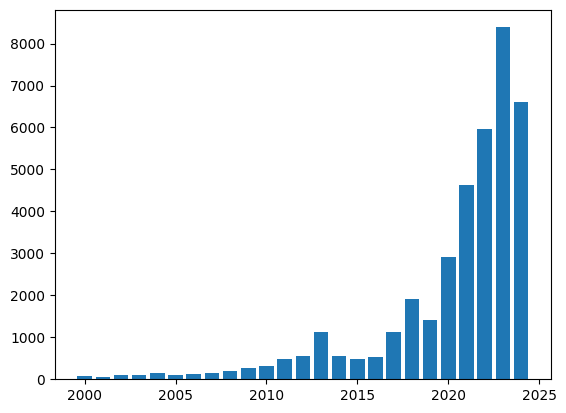

In [ ]:
# plot year_to_count
plt.bar(year_to_count.keys(), year_to_count.values())